In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animal-crossing/items.csv
/kaggle/input/animal-crossing/villagers.csv
/kaggle/input/animal-crossing/user_reviews.csv
/kaggle/input/animal-crossing/critic.csv


# Understanding User Sentiments and Future Desires in Animal Crossing Reviews

# Step-1: Data Loading and Cleaning

## Data loading

In [2]:
df_reviews = pd.read_csv('/kaggle/input/animal-crossing/user_reviews.csv')

In [3]:
df_reviews

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20
...,...,...,...,...
2994,1,TakezoShinmen,1 Island for console limitation.I cannot play ...,2020-05-03
2995,1,Pikey17,"Per giocare con figli o fidanzate, mogli o per...",2020-05-03
2996,0,Lemmeadem,One island per console is a pathetic limitatio...,2020-05-03
2997,2,TandemTester938,Even though it seems like a great game with ma...,2020-05-03


In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   grade      2999 non-null   int64 
 1   user_name  2999 non-null   object
 2   text       2999 non-null   object
 3   date       2999 non-null   object
dtypes: int64(1), object(3)
memory usage: 93.8+ KB


In [5]:
df_reviews.isnull().sum()

grade        0
user_name    0
text         0
date         0
dtype: int64

## Correct date format

In [6]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'])

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   grade      2999 non-null   int64         
 1   user_name  2999 non-null   object        
 2   text       2999 non-null   object        
 3   date       2999 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 93.8+ KB


# Step-2: Data Exploration and Preprocessing

## Language Detection

In [8]:
! pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=7c22c1873912cb39e8c91e2e2e210617e79914853a600dfb38f95c1c01e004a2
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [9]:
from langdetect import detect

df_reviews['language'] = df_reviews['text'].apply(detect)

In [10]:
df_reviews.language.value_counts()

language
en       2829
es        108
fr         18
pt         11
ru         11
it         10
de          4
pl          2
th          1
so          1
no          1
ko          1
zh-cn       1
fi          1
Name: count, dtype: int64

As majoirity of reviews are in english language. Thus, we can either ignore or translate the respective reviews to english

## Multilingual Translation

### Install Deepl for multilingual translation support

In [11]:
! pip install deepl

## Translate non-english reviews

In [12]:
import deepl

# Replace with your DeepL API key
auth_key = "53ccd28c-8ff3-44e5-9459-7cf4699f0cee:fx"#"your_deepl_api_key"
translator = deepl.Translator(auth_key)

# Translate non-English reviews
def translate_text(text, source_lang, target_lang="EN-GB"):
    try:
        result = translator.translate_text(text, source_lang=source_lang, target_lang=target_lang)
        return result.text
    except Exception as e:
        return f"Translation error: {e}"

# Filter non-English reviews
non_english_reviews = df_reviews[df_reviews['language'] != 'en'].copy()

# Translate non-English reviews
non_english_reviews['translated_text'] = non_english_reviews.apply(
    lambda row: translate_text(row['text'], source_lang=row['language'].upper()), axis=1
)

# Filter English reviews
english_reviews = df_reviews[df_reviews['language'] == 'en']

# Combine English and translated reviews
df_reviews = pd.concat([english_reviews, non_english_reviews], ignore_index=True)



In [13]:
non_english_reviews.translated_text.value_counts()

translated_text
Translation error: Quota for this billing period has been exceeded, message: Quota Exceeded    166
Translation error: Bad request, message: Value for 'source_lang' not supported.                  4
Name: count, dtype: int64

## Combine original and translated text

In [14]:
# Combine original and translated text
df_reviews['final_text'] = df_reviews.apply(
    lambda row: row['text'] if row['language'] == 'en' else row['translated_text'], axis=1
)

In [15]:
df_reviews

,grade,user_name,text,date,language,translated_text,final_text
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20,en,NaN,My gf started playing before me. No option to ...
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20,en,NaN,"While the game itself is great, really relaxin..."
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20,en,NaN,My wife and I were looking forward to playing ...
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20,en,NaN,We need equal values and opportunities for all...
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20,en,NaN,BEWARE! If you have multiple people in your h...
...,...,...,...,...,...,...,...
2994,10,ArisLink,Es el mejor Animal crossing de la historia y m...,2020-04-28,es,Translation error: Quota for this billing peri...,Translation error: Quota for this billing peri...
2995,7,Gemmo,Trovo che il gioco sia ben strutturato e lasci...,2020-04-28,it,Translation error: Quota for this billing peri...,Translation error: Quota for this billing peri...
2996,10,Jhonpo,El juego es maravilloso y que bien esta jugarl...,2020-04-29,es,Translation error: Quota for this billing peri...,Translation error: Quota for this billing peri...
2997,10,Dabaru,Me hacen gracia las notas bajas intentando des...,2020-05-02,es,Translation error: Quota for this billing peri...,Translation error: Quota for this billing peri...


## Filter out rows with translation errors

In [16]:
# Filter out rows with translation errors
df_reviews = df_reviews[~df_reviews['translated_text'].str.contains("Translation error", na=False)]

# Reset the index after filtering
df_reviews.reset_index(drop=True, inplace=True)


In [17]:
df_reviews['translated_text'].str.contains("Translation error", na=False).sum()

0

In [18]:
df_reviews.translated_text.value_counts()

Series([], Name: count, dtype: int64)

In [19]:
df_reviews.shape

(2829, 7)

In [20]:
df_reviews.isnull().sum()

grade                 0
user_name             0
text                  0
date                  0
language              0
translated_text    2829
final_text            0
dtype: int64

In [21]:
df_reviews.columns

Index(['grade', 'user_name', 'text', 'date', 'language', 'translated_text',
       'final_text'],
      dtype='object')

## Final dataset for preprocessing

In [22]:
df_reviews_final = df_reviews[['grade', 'user_name', 'date', 'final_text']]


In [23]:
df_reviews_final

,grade,user_name,date,final_text
0,4,mds27272,2020-03-20,My gf started playing before me. No option to ...
1,5,lolo2178,2020-03-20,"While the game itself is great, really relaxin..."
2,0,Roachant,2020-03-20,My wife and I were looking forward to playing ...
3,0,Houndf,2020-03-20,We need equal values and opportunities for all...
4,0,ProfessorFox,2020-03-20,BEWARE! If you have multiple people in your h...
...,...,...,...,...
2824,0,crazycasti,2020-05-03,For those who say I don't understand review bo...
2825,1,TakezoShinmen,2020-05-03,1 Island for console limitation.I cannot play ...
2826,0,Lemmeadem,2020-05-03,One island per console is a pathetic limitatio...
2827,2,TandemTester938,2020-05-03,Even though it seems like a great game with ma...


In [24]:
df_reviews_final.to_csv('final_traslate.csv')

In [25]:
df_reviews_final = pd.read_csv('final_traslate.csv')

## Check grade distribution

<Axes: title={'center': 'Grade Distribution'}, xlabel='grade'>

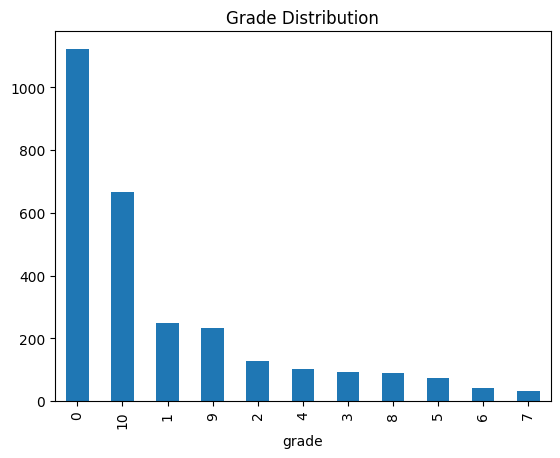

In [26]:
# Grade distribution
df_reviews_final['grade'].value_counts().plot(kind='bar', title='Grade Distribution')

## Word count distribution

<Axes: title={'center': 'Word Count Distribution'}, ylabel='Frequency'>

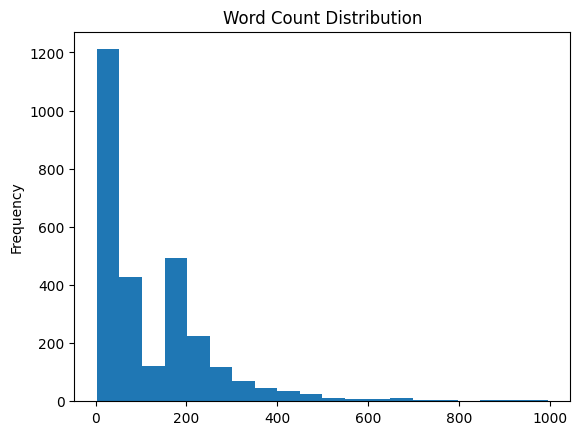

In [27]:
# Word count distribution
df_reviews_final['word_count'] = df_reviews_final['final_text'].str.split().apply(len)
df_reviews_final['word_count'].plot(kind='hist', bins=20, title='Word Count Distribution')

## Text Preprocessing

### Cleaning reviews

In [28]:
import re

def clean_text(text):
    # Remove URLs, HTML tags, and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text.strip()

    
df_reviews_final.loc[:, 'cleaned_text'] = df_reviews_final['final_text'].apply(clean_text)



In [29]:
df_reviews_final

,Unnamed: 0,grade,user_name,date,final_text,word_count,cleaned_text
0,0,4,mds27272,2020-03-20,My gf started playing before me. No option to ...,70,my gf started playing before me no option to c...
1,1,5,lolo2178,2020-03-20,"While the game itself is great, really relaxin...",167,while the game itself is great really relaxing...
2,2,0,Roachant,2020-03-20,My wife and I were looking forward to playing ...,185,my wife and i were looking forward to playing ...
3,3,0,Houndf,2020-03-20,We need equal values and opportunities for all...,56,we need equal values and opportunities for all...
4,4,0,ProfessorFox,2020-03-20,BEWARE! If you have multiple people in your h...,183,beware if you have multiple people in your ho...
...,...,...,...,...,...,...,...
2824,2824,0,crazycasti,2020-05-03,For those who say I don't understand review bo...,18,for those who say i dont understand review bom...
2825,2825,1,TakezoShinmen,2020-05-03,1 Island for console limitation.I cannot play ...,25,1 island for console limitationi cannot play t...
2826,2826,0,Lemmeadem,2020-05-03,One island per console is a pathetic limitatio...,69,one island per console is a pathetic limitatio...
2827,2827,2,TandemTester938,2020-05-03,Even though it seems like a great game with ma...,45,even though it seems like a great game with ma...


## Tokenisation

In [30]:
from nltk.tokenize import word_tokenize

df_reviews_final['tokens'] = df_reviews_final['cleaned_text'].apply(word_tokenize)


In [31]:
df_reviews_final

,Unnamed: 0,grade,user_name,date,final_text,word_count,cleaned_text,tokens
0,0,4,mds27272,2020-03-20,My gf started playing before me. No option to ...,70,my gf started playing before me no option to c...,"[my, gf, started, playing, before, me, no, opt..."
1,1,5,lolo2178,2020-03-20,"While the game itself is great, really relaxin...",167,while the game itself is great really relaxing...,"[while, the, game, itself, is, great, really, ..."
2,2,0,Roachant,2020-03-20,My wife and I were looking forward to playing ...,185,my wife and i were looking forward to playing ...,"[my, wife, and, i, were, looking, forward, to,..."
3,3,0,Houndf,2020-03-20,We need equal values and opportunities for all...,56,we need equal values and opportunities for all...,"[we, need, equal, values, and, opportunities, ..."
4,4,0,ProfessorFox,2020-03-20,BEWARE! If you have multiple people in your h...,183,beware if you have multiple people in your ho...,"[beware, if, you, have, multiple, people, in, ..."
...,...,...,...,...,...,...,...,...
2824,2824,0,crazycasti,2020-05-03,For those who say I don't understand review bo...,18,for those who say i dont understand review bom...,"[for, those, who, say, i, dont, understand, re..."
2825,2825,1,TakezoShinmen,2020-05-03,1 Island for console limitation.I cannot play ...,25,1 island for console limitationi cannot play t...,"[1, island, for, console, limitationi, can, no..."
2826,2826,0,Lemmeadem,2020-05-03,One island per console is a pathetic limitatio...,69,one island per console is a pathetic limitatio...,"[one, island, per, console, is, a, pathetic, l..."
2827,2827,2,TandemTester938,2020-05-03,Even though it seems like a great game with ma...,45,even though it seems like a great game with ma...,"[even, though, it, seems, like, a, great, game..."


## Remove stop words

In [32]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove stopwords from tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply to your tokenized column
df_reviews_final['tokens'] = df_reviews_final['tokens'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Check word similarity

### Define model

In [33]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=df_reviews_final['tokens'], vector_size=100, window=5, min_count=1)
word_vectors = model.wv


In [34]:
# Check the most similar words for a given word
similar_words = word_vectors.most_similar('improve', topn=10)
print(similar_words)


[('progressing', 0.9970157742500305), ('leader', 0.9969896078109741), ('lose', 0.9968501925468445), ('deserted', 0.996793806552887), ('impact', 0.9967170357704163), ('complete', 0.9965176582336426), ('either', 0.9962949752807617), ('instead', 0.9961351156234741), ('whatever', 0.9960331916809082), ('hand', 0.9959871768951416)]


##  visualize word embeddings

['game']
[[-0.5014551   1.0085983   0.3251902   0.01633464  0.3519032  -1.3750861
   0.7675229   1.950222   -0.28453386 -0.7124277  -0.1483951  -1.0006307
  -0.46081033 -0.09582587 -0.36265174 -0.43895873  0.59139216 -0.19404839
   0.0932411  -1.5189137   0.38486326  0.51472616  0.69896    -0.12576115
   0.07023147 -0.06292486 -0.621503   -0.30077323 -0.5690724   0.21849743
   0.6815162  -0.15565047  0.27820227 -0.97419256 -0.14028637  0.551352
   0.10305198 -0.24080537 -0.4977778  -0.8832416   0.395009   -0.39859176
  -0.09991446 -0.115459    0.35595417 -0.11904922 -0.51768064 -0.06477232
   0.7313853   0.5478245   0.36571977 -0.74670464 -0.10983454 -0.8149489
  -0.08040746  0.14132595  0.20777388 -0.04480461 -0.3109381   0.5504402
  -0.27549514  0.15774576  0.63245    -0.21933205 -0.813423    0.5823632
   0.81799483  0.64398795 -1.3167334   0.68660355  0.04218259  0.38020438
   0.83606106 -0.33247966  0.75587606  0.22871663  0.70225513 -0.07377696
  -0.61461794  0.12504601 -0.7419248

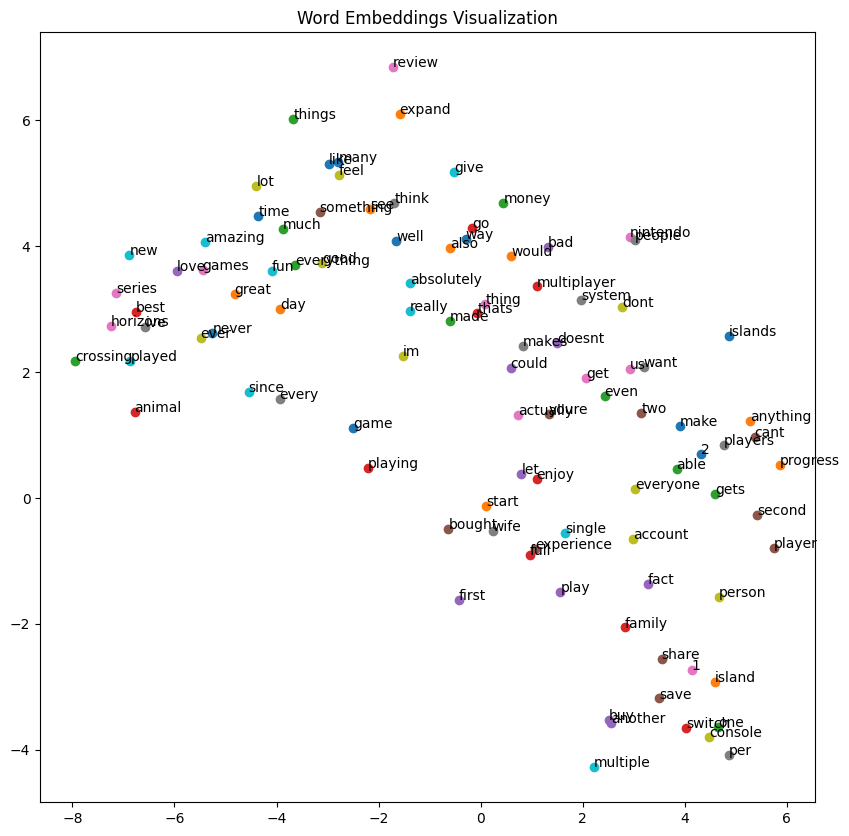

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get word vectors and their corresponding words
words = list(model.wv.index_to_key)
print(words[:1])
word_vectors = model.wv[words]

print(word_vectors[:1])

# Use t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(word_vectors[:100])  # Use the first 100 words for visualization
print(reduced_vectors[1])
# Plot the embeddings
plt.figure(figsize=(10, 10))
for i, word in enumerate(words[:100]):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
    plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], word)
plt.title("Word Embeddings Visualization")
plt.show()



* Clustering:
    * Words that are semantically or contextually similar are placed closer together.
        * For example:Words like animal, crossing, and game may cluster near each other if they frequently appear in similar contexts in the reviews.
* Spread:
    * Common words like the, is, and may be scattered because they don't carry much contextual meaning (stopwords).
    * We might consider removing them for certain tasks.

* Domain-Specific Relationships:
    * Words like multiplayer, Nintendo, and games likely form a distinct cluster related to gaming concepts



## Convert tokens to Vector

In [36]:
import numpy as np

def get_review_vector(review_tokens, model):
    vectors = [model.wv[word] for word in review_tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Average the vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are in the model

df_reviews_final['review_vector'] = df_reviews_final['tokens'].apply(lambda x: get_review_vector(x, model))


In [37]:
df_reviews_final

,Unnamed: 0,grade,user_name,date,final_text,word_count,cleaned_text,tokens,review_vector
0,0,4,mds27272,2020-03-20,My gf started playing before me. No option to ...,70,my gf started playing before me no option to c...,"[gf, started, playing, option, create, island,...","[-0.18828304, 0.86031, 0.24914742, 0.23948339,..."
1,1,5,lolo2178,2020-03-20,"While the game itself is great, really relaxin...",167,while the game itself is great really relaxing...,"[game, great, really, relaxing, gorgeous, cant...","[-0.18061243, 0.8562481, 0.23756666, 0.2535703..."
2,2,0,Roachant,2020-03-20,My wife and I were looking forward to playing ...,185,my wife and i were looking forward to playing ...,"[wife, looking, forward, playing, game, releas...","[-0.21648963, 0.86569756, 0.251838, 0.18133356..."
3,3,0,Houndf,2020-03-20,We need equal values and opportunities for all...,56,we need equal values and opportunities for all...,"[need, equal, values, opportunities, players, ...","[-0.14054768, 0.78716236, 0.21677695, 0.174013..."
4,4,0,ProfessorFox,2020-03-20,BEWARE! If you have multiple people in your h...,183,beware if you have multiple people in your ho...,"[beware, multiple, people, house, want, play, ...","[-0.21031998, 0.9382239, 0.25140205, 0.3343464..."
...,...,...,...,...,...,...,...,...,...
2824,2824,0,crazycasti,2020-05-03,For those who say I don't understand review bo...,18,for those who say i dont understand review bom...,"[say, dont, understand, review, bombing, well,...","[-0.1137369, 0.7372973, 0.12599204, 0.07877634..."
2825,2825,1,TakezoShinmen,2020-05-03,1 Island for console limitation.I cannot play ...,25,1 island for console limitationi cannot play t...,"[1, island, console, limitationi, play, game, ...","[-0.27313885, 0.82128274, 0.2462727, 0.1242940..."
2826,2826,0,Lemmeadem,2020-05-03,One island per console is a pathetic limitatio...,69,one island per console is a pathetic limitatio...,"[one, island, per, console, pathetic, limitati...","[-0.14336357, 0.6692201, 0.19016878, 0.2588650..."
2827,2827,2,TandemTester938,2020-05-03,Even though it seems like a great game with ma...,45,even though it seems like a great game with ma...,"[even, though, seems, like, great, game, many,...","[-0.14229026, 0.8000876, 0.21208444, 0.1946268..."


## Train Test Split

In [38]:
from sklearn.model_selection import train_test_split


# Create review-level vectors
X = np.stack(df_reviews_final['review_vector'].values)
y = df_reviews_final['grade'].apply(lambda g: 1 if g >= 6 else 0)  # Positive sentiment: grade >= 6

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step-3: Model training for sentiment analysis and word clustering

### Model definition for sentiment classification

In [39]:
from sklearn.linear_model import LogisticRegression

# Train sentiment classifier
model_logis = LogisticRegression()
model_logis.fit(X_train, y_train)


LogisticRegression()

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Evaluate model
predictions = model_logis.predict(X_test)
print(classification_report(y_test, predictions))
print(f"accuracy score: {accuracy_score(y_test, predictions)}")
print(f"confusion matrix: \n {confusion_matrix(y_test, predictions)}")

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       372
           1       0.80      0.70      0.75       194

    accuracy                           0.84       566
   macro avg       0.83      0.80      0.81       566
weighted avg       0.84      0.84      0.83       566

accuracy score: 0.8374558303886925
confusion matrix: 
 [[338  34]
 [ 58 136]]


## Word clustring

In [41]:
from sklearn.cluster import KMeans

# Apply KMeans clustering on word vectors
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

print(word_vectors)
kmeans.fit(word_vectors[:100])  # Use the first 100 words for simplicity

print(kmeans.labels_)

# Get cluster labels for words
clusters = kmeans.labels_

# Print words grouped by cluster
from collections import defaultdict
cluster_map = defaultdict(list)
for idx, label in enumerate(clusters):
    cluster_map[label].append(words[idx])

for cluster_id, word_list in cluster_map.items():
    print(f"Cluster {cluster_id}: {word_list}")


[[-5.01455128e-01  1.00859833e+00  3.25190187e-01 ... -2.63360769e-01
   2.27294490e-02  3.12877059e-01]
 [-3.63617539e-01  1.50518990e+00  5.58951259e-01 ... -5.67362070e-01
   1.78491101e-01 -9.44490254e-01]
 [-3.69685352e-01  1.66198671e+00  4.75755453e-01 ... -2.43163519e-02
   3.29347998e-01 -4.92201090e-01]
 ...
 [ 2.21753347e-04  1.20387208e-02  8.59156530e-03 ... -1.83220860e-02
   3.36620375e-03 -7.00970506e-03]
 [ 1.05125075e-02  4.50543687e-03  9.40639153e-03 ... -1.10077094e-02
  -5.02172159e-03 -7.32165249e-03]
 [ 6.12401729e-03 -1.74018904e-03  1.18915702e-03 ... -3.30432830e-03
  -5.19557018e-03 -1.19915484e-02]]
[0 1 1 1 3 3 2 1 1 4 0 0 4 4 3 3 2 2 2 2 0 2 2 0 1 3 0 2 2 0 3 0 0 2 2 3 1
 3 3 1 2 3 0 1 1 1 0 0 0 4 1 2 3 3 0 3 4 4 0 0 0 0 2 4 1 1 2 2 3 2 3 0 3 3
 2 2 4 0 3 3 0 3 0 2 2 2 2 3 0 0 0 3 2 2 2 0 2 2 0 2]
Cluster 0: ['game', 'like', 'expand', 'time', 'playing', 'games', 'fun', 'great', 'much', 'things', 'review', 'every', 'good', 'love', 'lot', 'since', 'many', '

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Cluster explanation

- Cluster 0
    - words : 'play', 'player', 'first', 'cant', 'experience', 'make', 'second', 'players', 'person', 'progress', 'able', 'fact', 'everyone', '2', 'gets', 'full', 'account', 'single', 'anything', 'wife'
    - Theme : Player interactions and progress in the game

- Cluster 1
    - words: 'like', 'expand', 'really', 'time', 'playing', 'games', 'im', 'fun', 'great', 'much', 'things', 'review', 'every', 'good', 'love', 'lot', 'since', 'many', 'day', 'see', 'think', 'never', 'everything', 'ever', 'amazing', 'well', 'something', 'feel'
    - Theme : Emotions and general sentiments about the game.

- Cluster 2
    - words: 'new', 'crossing', 'animal', 'played', 'series', 'ive', 'best', 'horizons'
    - Theme: The "Animal Crossing" series and its overall reception.

- Cluster 3
    - words: 'island', 'one', 'switch', 'per', 'console', 'buy', '1', 'multiple', 'family', 'another', 'share', 'islands', 'save'
    - Theme: Realated to game mechanics and console

- Cluster 4
    - words: 'game', 'nintendo', 'get', 'people', 'dont', 'would', 'even', 'want', 'multiplayer', 'could', 'way', 'also', 'enjoy', 'bought', 'made', 'thing', 'system', 'give', 'doesnt', 'two', 'thats', 'bad', 'youre', 'us', 'start', 'money', 'go', 'let', 'actually', 'makes', 'absolutely'
    - Theme: General discussions and opinions about the game and its features and improvement

## Handel imbalance train data

In [42]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [43]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression on the balanced dataset
model_balanced = LogisticRegression(random_state=42)
model_balanced.fit(X_train_balanced, y_train_balanced)


LogisticRegression(random_state=42)

## Training model with balance dataset

In [44]:

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred_bal = model_balanced.predict(X_test)



# Evaluate balance model
predictions = model_logis.predict(X_test)
print(classification_report(y_test, y_pred_bal))
print(f"accuracy score: {accuracy_score(y_test, y_pred_bal)}")
print(f"confusion matrix: \n {confusion_matrix(y_test, y_pred_bal)}")

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       372
           1       0.77      0.79      0.78       194

    accuracy                           0.85       566
   macro avg       0.83      0.83      0.83       566
weighted avg       0.85      0.85      0.85       566

accuracy score: 0.8462897526501767
confusion matrix: 
 [[325  47]
 [ 40 154]]


# Step 4 :  Hyper-parameter testing

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
grid = GridSearchCV(LogisticRegression(max_iter=4000), param_grid, cv=5)
grid.fit(X_train_balanced, y_train_balanced)
grid.best_params_


{'C': 10, 'solver': 'lbfgs'}

In [46]:
# Get the best parameters
best_params = grid.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 10, 'solver': 'lbfgs'}


In [47]:
# Get the best estimator (model)
best_model = grid.best_estimator_
print("Best Model:", best_model)


Best Model: LogisticRegression(C=10, max_iter=4000)


In [48]:
# Predict using the best model
y_pred_best_model = best_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import classification_report, accuracy_score

## Check Roc-AUC curve

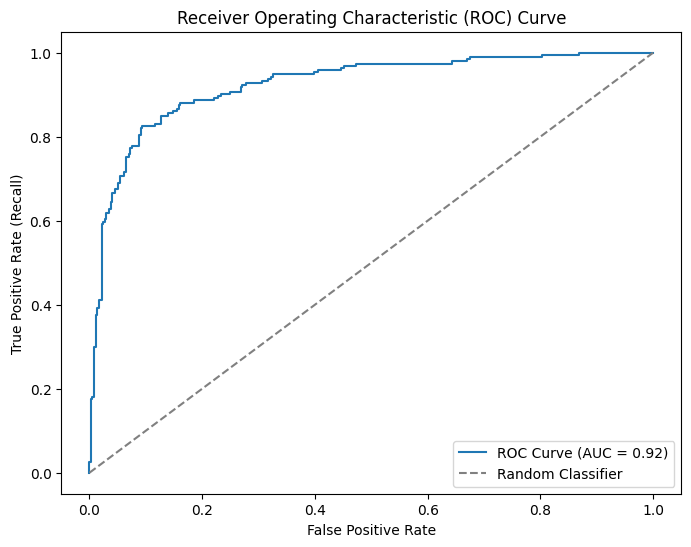

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probs = best_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_probs):.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.show()


Optimal Threshold: 0.5329966796163705
Optimal Threshold - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       372
           1       0.82      0.82      0.82       194

    accuracy                           0.88       566
   macro avg       0.86      0.87      0.86       566
weighted avg       0.88      0.88      0.88       566

Optimal Threshold - Accuracy: 0.8780918727915195


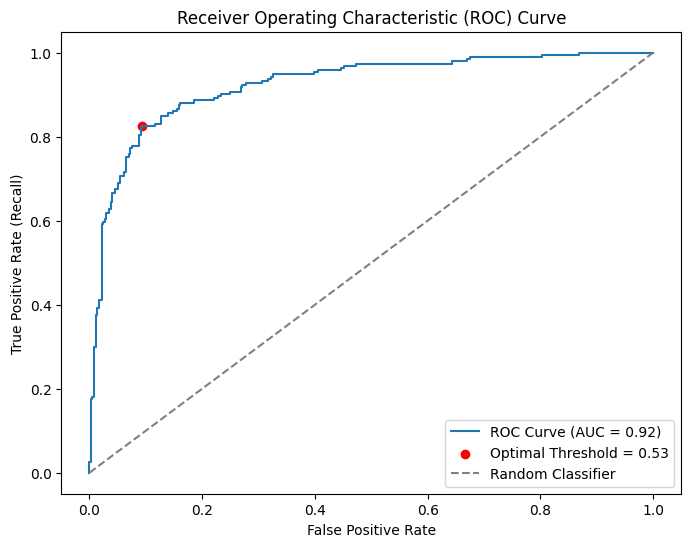

In [50]:
# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)  # Maximize TPR - FPR
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

# Evaluate the new predictions
print("Optimal Threshold - Classification Report:")
print(classification_report(y_test, y_pred_optimal))

# Calculate accuracy
accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
print("Optimal Threshold - Accuracy:", accuracy_optimal)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_probs):.2f})")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.show()


In [51]:
from sklearn.metrics import precision_recall_curve

y_probs = best_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Set a custom threshold (e.g., 0.4 instead of 0.5)
optimal_threshold = 0.45
y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)


In [52]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the new predictions
print("Adjusted Threshold (0.45) - Classification Report:")
print(classification_report(y_test, y_pred_adjusted))

# Calculate accuracy
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
print("Adjusted Threshold (0.45) - Accuracy:", accuracy_adjusted)

print(classification_report(y_test, y_pred_best_model))
print(f"accuracy score: {accuracy_score(y_test, y_pred_best_model)}")
print(f"confusion matrix: \n {confusion_matrix(y_test, y_pred_best_model)}")

Adjusted Threshold (0.45) - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       372
           1       0.78      0.84      0.80       194

    accuracy                           0.86       566
   macro avg       0.84      0.85      0.85       566
weighted avg       0.86      0.86      0.86       566

Adjusted Threshold (0.45) - Accuracy: 0.8604240282685512
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       372
           1       0.80      0.82      0.81       194

    accuracy                           0.87       566
   macro avg       0.85      0.86      0.85       566
weighted avg       0.87      0.87      0.87       566

accuracy score: 0.8674911660777385
confusion matrix: 
 [[331  41]
 [ 34 160]]


In [53]:
! pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


# Step 5: Sentiment analysis on identified Clusters

In [54]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import defaultdict

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define clusters (as provided in your example)
clusters = {
    3: ['game', 'nintendo', 'get', 'people', 'dont', 'really', 'would', 'even', 'playing', 'want', 'im', 'make', 
        'multiplayer', 'could', 'way', 'also', 'enjoy', 'made', 'thing', 'system', 'give', 'doesnt', 'two', 
        'think', 'thats', 'bad', 'youre', 'us', 'money', 'go', 'let', 'actually', 'makes', 'absolutely'],
    2: ['island', 'one', 'switch', 'per', 'console', 'buy', '1', 'multiple', 'family', 'another', 'share', 
        'islands', 'fact', 'save'],
    0: ['play', 'player', 'first', 'cant', 'experience', 'second', 'players', 'person', 'progress', 'able', 
        'bought', 'everyone', '2', 'gets', 'full', 'account', 'single', 'anything', 'wife', 'start'],
    1: ['new', 'crossing', 'animal', 'played', 'series', 'ive', 'since', 'best', 'horizons', 'ever'],
    4: ['like', 'expand', 'time', 'games', 'fun', 'great', 'much', 'things', 'review', 'every', 'good', 'love', 
        'lot', 'many', 'day', 'see', 'never', 'everything', 'amazing', 'well', 'something', 'feel']
}

# Calculate sentiment for each cluster
cluster_sentiments = {}
for cluster_id, words in clusters.items():
    sentiment_scores = defaultdict(float)
    for word in words:
        sentiment = analyzer.polarity_scores(word)  # Get sentiment scores for the word
        sentiment_scores['pos'] += sentiment['pos']  # Sum up positive scores
        sentiment_scores['neg'] += sentiment['neg']  # Sum up negative scores
        sentiment_scores['neu'] += sentiment['neu']  # Sum up neutral scores
    
    # Normalize scores by the number of words in the cluster
    num_words = len(words)
    cluster_sentiments[cluster_id] = {
        'positive': sentiment_scores['pos'] / num_words,
        'negative': sentiment_scores['neg'] / num_words,
        'neutral': sentiment_scores['neu'] / num_words
    }

# Print sentiment analysis results
for cluster_id, sentiments in cluster_sentiments.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Positive Sentiment: {sentiments['positive']:.2f}")
    print(f"  Negative Sentiment: {sentiments['negative']:.2f}")
    print(f"  Neutral Sentiment: {sentiments['neutral']:.2f}")
    print()


Cluster 3:
  Positive Sentiment: 0.09
  Negative Sentiment: 0.03
  Neutral Sentiment: 0.88

Cluster 2:
  Positive Sentiment: 0.14
  Negative Sentiment: 0.00
  Neutral Sentiment: 0.86

Cluster 0:
  Positive Sentiment: 0.10
  Negative Sentiment: 0.00
  Neutral Sentiment: 0.90

Cluster 1:
  Positive Sentiment: 0.20
  Negative Sentiment: 0.00
  Neutral Sentiment: 0.80

Cluster 4:
  Positive Sentiment: 0.36
  Negative Sentiment: 0.00
  Neutral Sentiment: 0.64

